# Superdense Coding
In this tutorial, we construct an implementation of the superdense coding protocol via Amazon Braket's SDK.

**Superdense coding** is a method of transmitting two classical bits by sending only one qubit. Starting with a pair of entanged qubits, the sender (aka Alice) applies a certain quantum gate to their qubit and sends the result to the receiver (aka Bob), who is then able to decode the full two-bit message.

If Alice wants to send a two-bit message to Bob using only classical channels, she would need to send two classical bits. However, with the help of quantum entanglement, Alice can do this by sending just one qubit. By ensuring that Alice and Bob initially share an entangled state of two qubits, they can devise a strategy such that Alice can transmit her two-bit message by sending her single qubit.

To implement superdense coding, Alice and Bob need to share or otherwise prepare a maximally entangled pair of qubits (i.e., a Bell pair). Alice then selects one of the four possible messages to send with two classical bits: 00, 01, 10, or 11. Depending on which two-bit string she wants to send, Alice applies a corresponding quantum gate to encode her desired message. Finally, Alice sends her own qubit to Bob, which Bob then uses to decode the message by undoing the initial entangling operation.

Note that superdense coding is closely related to quantum teleportation:

- in teleportation, one uses an entangled pair (an e-bit) and two uses a classical channel to simulate a single use of a quantum channel
- in superdense coding, one uses an e-bit and a single use of a quantum channel to simulate two uses of a classical channel.


## Detailed Steps
1. Alice and Bob initially share a Bell pair. Alice holds one of these two qubits, while Bob holds the other.
2. Alice selects one of the four possible messages to send Bob. Each message corresponds to a unique set of quantum gate(s) to apply to her own qubit, illustrated in the table below.  For example, if Alice wants to send the message "01", she would apply the Pauli X gate.
3. Alice sends her qubit to Bob through the quantum channel.
4. Bob decodes Alice's two-bit message by first applying a CNOT gate using Alice's qubit as the control and his own qubit as the target, and then a Hadamard gate on Alice's qubit to restore the classical message.

| Message | Alice's encoding | State Bob receives<br>(non-normalized) | After ùê∂ùëã gate<br>(non-normalized) | After ùêª gate |
| :---: | :---: | :---: | :---: | :---: |
| 00 | ùêº | \|00‚ü© + \|11‚ü© | \|00‚ü© + \|10‚ü© | \|00‚ü©
| 01 | ùëã | \|10‚ü© + \|01‚ü© | \|11‚ü© + \|01‚ü© | \|01‚ü©
| 10 | ùëç | \|00‚ü© - \|11‚ü© | \|00‚ü© - \|10‚ü© | \|10‚ü©
| 11 | ùëçùëã | \|01‚ü© - \|10‚ü© | \|01‚ü© - \|11‚ü© | \|11‚ü©


## Circuit Diagram

Circuit used to send the message "00". To send other messages, swap out the identity (ùêº) gate.
<div align="center"><img src="circuit.png"/></div>
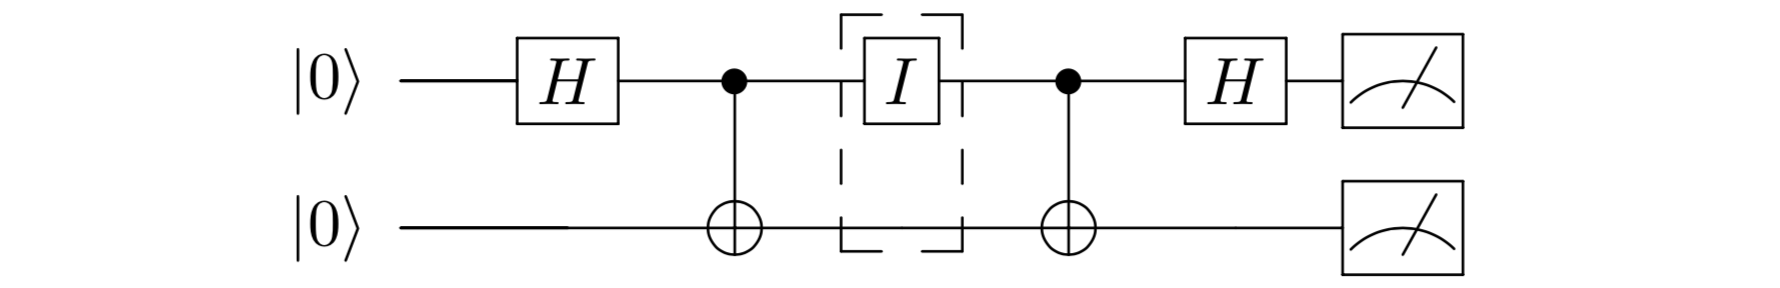

## Code

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from braket.aws import AwsDevice
from braket.circuits import Circuit
from braket.devices import LocalSimulator

Typically, we recommend running circuits with fewer than 25 qubits on the local simulator to avoid latency bottlenecks. The on-demand, high-performance simulator SV1 is better suited for larger circuits up to 34 qubits. Nevertheless, for demonstration purposes, we are going to continue this example with SV1 but it is easy to switch over to the local simulator by replacing the last line in the cell below with ```device = LocalSimulator()``` and importing the ```LocalSimulator```.


In [2]:
# device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")
device = LocalSimulator()


In [11]:
def get_result(device, circ, plot_counts=False):
    """run quantum task, check the status thereof and collect results"""

    num_qubits = circ.qubit_count

    # specify desired results_types
    circ.probability()

    if device.name == "StateVectorSimulator":
        task = device.run(circ, shots=1000)
    else:
        task = device.run(circ, shots=1000)

    task_id = task.id
    print(f"{task_id = }")

    # Wait for job to complete
    status = task.state()
    while status != "COMPLETED":
        status = task.state()
        sleep(2)

    result = task.result()
    metadata = result.task_metadata
    probs_values = result.values[0]
    measurement_counts = result.measurement_counts

    print(f"{measurement_counts = }")

    # bitstrings
    format_bitstring = "{0:0" + str(num_qubits) + "b}"
    bitstring_keys = [format_bitstring.format(ii) for ii in range(2**num_qubits)]

    # plot probabalities
    if plot_counts:
        plt.bar(bitstring_keys, probs_values)
        plt.xlabel("bitstrings")
        plt.ylabel("probability")
        plt.xticks(rotation=90)
        plt.show()

    return measurement_counts


In [12]:
def superdence_coding_circuit(message: str):
    # Four possible messages and their corresponding gates
    messages = {
        "00": Circuit().i(0),
        "01": Circuit().x(0),
        "10": Circuit().z(0),
        "11": Circuit().x(0).z(0),
    }
    assert message in messages

    circ = Circuit()

    # Alice and Bob initially share a Bell pair
    circ.h([0])
    circ.cnot(0, 1)

    # Alice encodes her message
    circ.add_circuit(messages[message])

    # Alice sends her qubit to Bob so that Bob has both qubits in his lab
    # Bob decodes Alice's message by disentangling the two qubits:
    circ.cnot(0, 1)
    circ.h([0])

    return circ


In [13]:
# Select message to send.  Let's start with '01' for now
message = "01"

circ = superdence_coding_circuit(message)
print(circ)


T  : |0|1|2|3|4|
                
q0 : -H-C-X-C-H-
        |   |   
q1 : ---X---X---

T  : |0|1|2|3|4|


By measuring the two qubits in the computational basis, Bob can read off Alice's two qubit message

task_id = 'fae3f176-761e-4d03-bc3b-c2972872d758'
measurement_counts = Counter({'01': 1000})


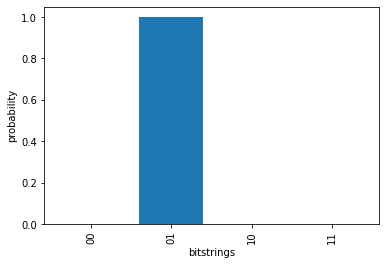

Counter({'01': 1000})


In [14]:
counts = get_result(device, circ, plot_counts=True)
print(counts)

We can check that this scheme works for the other possible messages too:

In [16]:
for message in ["00", "01", "10", "11"]:

    print(f"{message = }")

    circ = superdence_coding_circuit(message)
    counts = get_result(device, circ)

    print(f"{counts = }")
    print()


message = '00'
task_id = '87102a92-dceb-435f-818f-d8364a702917'
measurement_counts = Counter({'00': 1000})
counts = Counter({'00': 1000})

message = '01'
task_id = '4a850091-502e-4e25-a15b-de77ba28677d'
measurement_counts = Counter({'01': 1000})
counts = Counter({'01': 1000})

message = '10'
task_id = 'f5cc6d8e-46f5-4da6-b4c1-1053be2e2023'
measurement_counts = Counter({'10': 1000})
counts = Counter({'10': 1000})

message = '11'
task_id = '2d364cf0-0087-4def-8981-15f4679b3194'
measurement_counts = Counter({'11': 1000})
counts = Counter({'11': 1000})

